In [6]:
!git clone https://github.com/rhisehl/Customer-Churn-Model

Cloning into 'Customer-Churn-Model'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 5), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), 541.25 KiB | 2.46 MiB/s, done.


In [101]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [73]:
# Set up S3 import
!pip install boto3
import boto3

BUCKET_NAME = 'ecommerce-machine-learning-resources-5.29.23'

from config import aws_access_key_id, aws_secret_access_key, region

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
# Authentication credentials for S3
s3 = boto3.resource('s3',aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key)
KEY = 'cleaned_data.csv'
# Import file
s3.Bucket(BUCKET_NAME).download_file(KEY,'cleaned_data.csv')

In [75]:
# Read CSV into DataFrame
df = pd.read_csv('cleaned_data.csv',index_col=0)
df.set_index("CustomerID",inplace=True)
df

,Churn,Tenure,PreferredLoginDevice,PreferredPaymentMode,Gender,AppHours,RegisteredDevices,PreferredCategory,SatisfactionScore,MaritalStatus,...,OrderIncreasePercent,CouponsUsed,OrderCount,DaysSinceOrder,AverageCashback,State,Age,Race,HouseholdIncome,PersonalIncome
CustomerID,,,,,,,,,,,,,,,,,,,,,
50001,1,4.0,Mobile Phone,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,...,11.0,1.0,1.0,5.0,160,California,75,White,17334.97,17334.97
50004,1,0.0,Phone,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,...,23.0,0.0,1.0,3.0,134,Pennsylvania,24,White,203600.87,37389.14
50006,1,0.0,Computer,Debit Card,Female,3.0,5,Mobile Phone,5,Single,...,22.0,4.0,6.0,7.0,139,Mississippi,32,Black,2379.31,2379.31
50012,1,11.0,Mobile Phone,Debit Card,Male,3.0,4,Fashion,3,Single,...,13.0,0.0,1.0,0.0,154,New York,83,White,26461.31,26461.31
50013,1,0.0,Phone,COD,Male,2.0,3,Mobile,3,Single,...,13.0,2.0,2.0,2.0,134,Washington,39,American Indian or Alaska Native,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55625,0,1.0,Mobile Phone,UPI,Female,2.0,5,Mobile Phone,3,Single,...,19.0,2.0,2.0,1.0,155,Louisiana,93,White,13766.00,13766.00
55626,0,10.0,Computer,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,...,18.0,1.0,2.0,4.0,151,North Carolina,25,Black,64581.24,47586.18
55628,0,1.0,Mobile Phone,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,...,21.0,1.0,2.0,4.0,186,Texas,46,White,85026.30,51036.18


In [79]:
clean_df = df

# convert categorical data to numeric with `pd.get_dummies`
df2 = clean_df.copy()
df = pd.get_dummies(df2)
df

,Churn,Tenure,AppHours,RegisteredDevices,SatisfactionScore,NumberAddresses,Complaint,OrderIncreasePercent,CouponsUsed,OrderCount,...,State_West Virginia,State_Wisconsin,Race_American Indian or Alaska Native,Race_Black,Race_Chinese,Race_Japanese,Race_Other,Race_Other Asian or Pacific Islander,Race_Two major races,Race_White
CustomerID,,,,,,,,,,,,,,,,,,,,,
50001,1,4.0,3.0,3,2,9,1,11.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
50004,1,0.0,2.0,4,5,8,0,23.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
50006,1,0.0,3.0,5,5,2,1,22.0,4.0,6.0,...,0,0,0,1,0,0,0,0,0,0
50012,1,11.0,3.0,4,3,10,1,13.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
50013,1,0.0,2.0,3,3,2,1,13.0,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55625,0,1.0,2.0,5,3,2,0,19.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1
55626,0,10.0,3.0,2,1,6,0,18.0,1.0,2.0,...,0,0,0,1,0,0,0,0,0,0
55628,0,1.0,3.0,2,4,3,1,21.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,1


# Train, Validation, Test Datasets

In [80]:
# Reset dataset to begin with original data again
def start_dataset():

  # Separate the data into labels and features
    # the y variable, the labels (0 = Active Customer, 1 = Inactive Customer)
  y = df['Churn']
    # the X variable, the features
  X = df.drop(columns='Churn')

  # Split into testing and training sets using train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
  X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, random_state=1)

  # recombobulate datasets
  train = X_train.join(y_train)
  valid = X_valid.join(y_valid)
  test = X_test.join(y_test)

  return X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y

In [81]:
# Scale (normalize) the dataset to avoid skewing caused by numbers of various sizes
def scale_dataset(train, oversample=False):
    X = df[df.columns[:-1]].values
    y = df[df.columns[-1]].values

    # Instantiate a StandardScaler instance
    scaler = StandardScaler()

    # fit the data and transform
    X = scaler.fit_transform(X)
    
    # if we decide to use the RandomOverSampler module due to a large variance in record numbers
    ## to take more of a less class and increase the size of the dataset
    if oversample:
        ros = RandomOverSampler(sampling_strategy='minority')
        X, y = ros.fit_resample(X, y)
        
    # create one huge 2d numpy array (hstack, horizontal stack side by side)
    train = np.hstack((X, np.reshape(y, (-1,1))))
    
    # return fit and transformed data
    return train, X, y

In [82]:
# Calculate accuracy score and generate confusion matrix for print report
def accuracy_confusion(y_test, y_pred):
    # calculate the accuracy score for the test dataset
    acc_score = accuracy_score(y_test, y_pred)
    
    # generate a confusion matrix for the model
    cm_df_init = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(
            cm_df_init, index=['Actual Active Customer', 'Actual Inactive Customer'],
            columns=['Predicted Active Customer', 'Predicted Inactive Customer']
    )
      
    return(acc_score, cm_df)   

In [83]:
# Begin processing
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

In [84]:
# Verify all rows accounted for
df.shape[0], train.shape[0] + valid.shape[0] + test.shape[0]

(4025, 4025)

# Compile, Train and Evaluate the Machine Learning Models

In [90]:
# Create variables
cols = ['Tenure', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',	'AppHours',	'RegisteredDevices',	'PreferredCategory',	'SatisfactionScore',	'MaritalStatus',	'OrderIncreasePercent',	'CouponsUsed',	'OrderCount',	'DaysSinceOrder',	'AverageCashback',	'State',	'Age',	'Race',	'HouseholdIncome',	'PersonalIncome', 'Churn']
churn =['Active', 'Inactive']

##  kNN variables
oversamples = [ 'False', 'True']
neighbor_nums = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
# neighbor_nums = [] # for ideal scenario


#   Create a K-Nearest Neighbors (kNN) Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

# do for each in lists declared in the beginning
#  use kNN declared list variables
for neighbor_num in neighbor_nums:
    for oversample in oversamples:
        
        # scale (normalize) the datasets
        train, X_train, y_train = scale_dataset(train, oversample=oversample)
        valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
        test, X_test, y_test = scale_dataset(test, oversample=False)
        
        # fit the model using the original then the resampled training data   
          # using a pre-specified number of neighborhood points to classify a given point
        knn_model = KNeighborsClassifier(n_neighbors=neighbor_num)
        knn_model.fit(X_train, y_train)

        # make a prediction using the testing data
        y_pred = knn_model.predict(X_test)
        
        # calculate the accuracy score for the test dataset        
        # generate a confusion matrix for the model
        acc_score, cm_df = accuracy_confusion(y_test, y_pred)
        
        # print the classification reports
        print(('*' * 50)+'\n')  
        print('K-Nearest Neighbors (kNN) Model Reports')
        print(f'Parameters: {neighbor_num} n_neighbors and oversample={oversample}\n')
        # print('Confusion Matrix')
        # display(cm_df)
        print(f'Accuracy Score : {acc_score:.3%}\n')
        print('Classification Report')
        print(classification_report(y_test, y_pred, target_names=churn))

# Create Naive Bayes Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

# do for each in lists declared in the beginning
for oversample in oversamples:
    
    # scale (normalize) the train and test datasets            
    train, X_train, y_train = scale_dataset(train, oversample=oversample)
    valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
    test, X_test, y_test = scale_dataset(test, oversample=False)
    
    # fit the model using the original then the resampled training data
    nb_model = GaussianNB()
    nb_model = nb_model.fit(X_train, y_train)
    
    # make a prediction using the testing data
    y_pred = nb_model.predict(X_test)

    # calculate the accuracy score for the test dataset        
    # generate a confusion matrix for the model
    acc_score, cm_df = accuracy_confusion(y_test, y_pred)

    # print the classification reports
    print(('*' * 50)+'\n')  
    print('Naive Bayes Model Reports')
    print(f'Parameters: oversample={oversample}\n')
    # print('Confusion Matrix')
    # display(cm_df)
    print(f'Accuracy Score : {acc_score:.3%}\n')
    print(f'Classification Report')
    print(classification_report(y_test, y_pred, target_names=churn))

# Create Logistic Regression Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

# Fit the model using the original then the resampled training data,
for oversample in oversamples:
     
    # scale (normalize) the train and test datasets     
    train, X_train, y_train = scale_dataset(train, oversample=oversample)
    valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
    test, X_test, y_test = scale_dataset(test, oversample=False)
     
    # Fit the model using the original then the resampled training data
    lg_model = LogisticRegression()
    lg_model = lg_model.fit(X_train, y_train)
    
    # make a prediction using the testing data
    y_pred = lg_model.predict(X_test)
    
    # calculate the accuracy score for the test dataset        
    # generate a confusion matrix for the model
    acc_score, cm_df = accuracy_confusion(y_test, y_pred)

    # print the classification reports
    print(('*' * 50)+'\n')  
    print('Logistic Regression Model Reports')
    print(f'Parameters: oversample={oversample}\n')
    # print('Confusion Matrix')
    # display(cm_df)
    print(f'Accuracy Score : {acc_score:.3%}\n')
    print(f'Classification Report')
    print(classification_report(y_test, y_pred, target_names=churn))    

# Create Support Vector Machines (SVM) Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

# Fit the model using the original then the resampled training data,
for oversample in oversamples:
     
    # scale (normalize) the train and test datasets     
    train, X_train, y_train = scale_dataset(train, oversample=oversample)
    valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
    test, X_test, y_test = scale_dataset(test, oversample=False)
     
    # Fit the model using the original then the resampled training data
    svm_model = SVC()
    svm_model = svm_model.fit(X_train, y_train)
    
    # make a prediction using the testing data
    y_pred = svm_model.predict(X_test)
    
    # calculate the accuracy score for the test dataset        
    # generate a confusion matrix for the model
    acc_score, cm_df = accuracy_confusion(y_test, y_pred)

    # print the classification reports
    print(('*' * 50)+'\n')  
    print('Support Vector Machines (SVM) Model Reports')
    print(f'Parameters: oversample={oversample}\n')
    # print('Confusion Matrix')
    # display(cm_df)
    print(f'Accuracy Score : {acc_score:.3%}\n')
    print(f'Classification Report')
    print(classification_report(y_test, y_pred, target_names=churn)) 

# Create Neural Networks Model with Reports

In [116]:
# Functions to plot the loss and accuracy for Neural Network Modeling
def plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, oversample, batch_size, epochs, save_graph ):
    filepath_plot = 'Customer-Churn-Model/Results/Neural_Network_Loss_Accuracy_Graph.png'
    # plot variables
    acc = f'{a_score:.3%}'
    los = f'{l_score}'
    s_title = f'Model: StandardScaler with {number_input_features} Features, Accuracy: {acc}'
    n_title = f'Nodes: {node}, dropout: {dropout_probability}, lr: {learning_rate}, ros: {oversample}, epochs: {epochs}, batch_size: {batch_size}, Loss: {los}'

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentrophy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    # ax2.set_ylabel('  ')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(s_title, ha='right')
    plt.title(n_title, ha='right')

    if save_graph == True:
      plt.savefig(filepath_plot)

    plt.show()

In [112]:
def train_model(X_train, y_train, nodes, dropout_probability, learning_rate, oversample, batch_size, epochs):
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
  nn = tf.keras.models.Sequential([
  # First hidden layer
      tf.keras.layers.Dense(nodes, input_dim=number_input_features, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Second hidden layer
      tf.keras.layers.Dense(nodes, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Output layer
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  # Check the structure of the model
  nn.summary()

  # Compile the model
  nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

  # Train the model
  history = nn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=0)

  return nn, history

In [113]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

# scale (normalize) the train and test datasets     
train, X_train, y_train = scale_dataset(train, oversample=oversample)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [114]:
# Define variables for Neural Network Modeling
number_input_features = len(X_train[0])
epochs = 96 
filepath = 'Customer-Churn-Model/Results/Churn_nn_model.h5'

8 nodes, dropout 0, lr 0.01, ros False, batch size 32, epochs=96
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 712       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 8)                 72        
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 793
Trainable params: 793
Non-trainable params: 0
_________________________________________________________

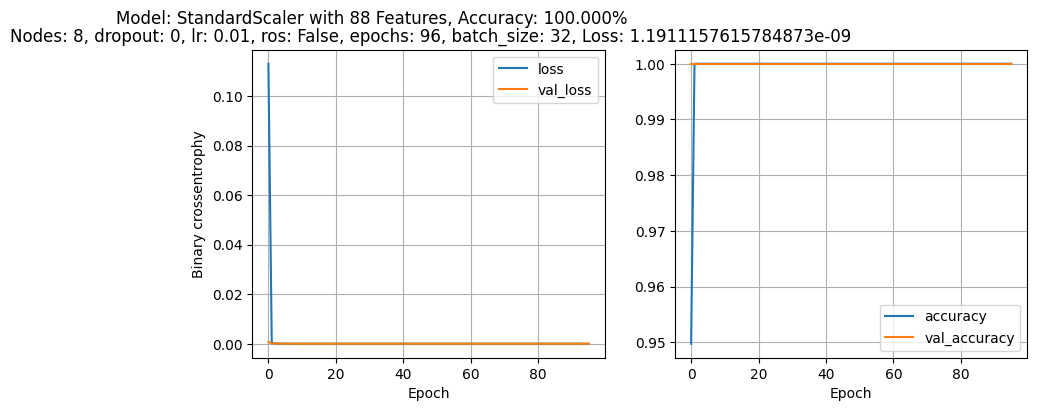

8 nodes, dropout 0, lr 0.01, ros False, batch size 64, epochs=96
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 8)                 712       
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 8)                 72        
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 793
Trainable params: 793
Non-trainable params: 0
_________________________________________________________

KeyboardInterrupt: ignored

In [118]:
# Set up and run model predictions
  # view the loss and accuracy of model
least_val_loss = float('inf')
least_loss_model = None

for oversample in oversamples:
  for node in [8, 16, 24]:
    for dropout_probability in [0, 0.2]:
      for learning_rate in [0.01, 0.005, 0.001]:
        for batch_size in [32, 64, 128]:
          print(f'{node} nodes, dropout {dropout_probability}, lr {learning_rate}, ros {oversample}, batch size {batch_size}, epochs={epochs}')
          nn, history = train_model(X_train, y_train, node, dropout_probability, learning_rate, oversample, batch_size, epochs)

          # calculate loss to find least loss (best model)
          loss_acc = nn.evaluate(X_valid, y_valid)
          a_score = loss_acc[1]  # model accuracy
          l_score = loss_acc[0]  # model loss  
          save_graph = False     
          # plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, oversample, batch_size, epochs, save_graph)
          
          if l_score < least_val_loss:
            least_val_loss = l_score
            least_loss_model = nn
            # save best model and graph
            tf.keras.saving.save_model(nn, filepath, overwrite=True, save_format=None)
            save_graph = True       
            plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, oversample, batch_size, epochs, save_graph)
